# Init

In [0]:
# Execute this code block to install dependencies when running on colab
try:
    import torch
except:
    from os.path import exists
    from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
    platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
    cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
    accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

    !pip install -q http://download.pytorch.org/whl/{accelerator}/torch-1.0.0-{platform}-linux_x86_64.whl torchvision

try: 
    import torchbearer
except:
    !pip install torchbearer

     |████████████████████████████████| 143kB 3.5MB/s 


# Prepare Penn Treebank dataset

In [0]:
# automatically reload external modules if they change
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchtext import data
from torchtext import vocab
from torchtext import datasets

import numpy as np
from matplotlib import pyplot as plt

from tqdm import tqdm

In [0]:
!pip install adabound

In [0]:
import adabound

In [0]:
tokenize = lambda x: x.split()
TEXT = data.Field(sequential = True, tokenize = tokenize, lower = True, batch_first = True)
train_dataset, val_dataset, test_dataset = datasets.PennTreebank.splits(TEXT)
TEXT.build_vocab(train_dataset, vectors=vocab.GloVe(name='6B', dim=300))

vocab_size = len(TEXT.vocab)
word_embeddings = TEXT.vocab.vectors
print(vocab_size)
print(word_embeddings.size())
embeddings_length = 300
hidden_size = 256
batch_size = 32

downloading ptb.train.txt


ptb.train.txt: 5.10MB [00:00, 60.5MB/s]                   


downloading ptb.valid.txt


ptb.valid.txt: 400kB [00:00, 12.3MB/s]                   


downloading ptb.test.txt


ptb.test.txt: 450kB [00:00, 14.4MB/s]                   
.vector_cache/glove.6B.zip: 862MB [06:27, 2.23MB/s]                           
100%|█████████▉| 399970/400000 [00:56<00:00, 7112.94it/s]

10001
torch.Size([10001, 300])


In [0]:
train_iter, val_iter, test_iter = data.BPTTIterator.splits((train_dataset, val_dataset, test_dataset), batch_size = 32, bptt_len=30, repeat=False)

In [0]:
class LstmLangModel(nn.Module):
   def __init__(self, batch_size, hidden_size, vocab_size, embeddings_length, weights):
       super(LstmLangModel, self).__init__()
       self.batch_size = batch_size
       self.hidden_size = hidden_size
       self.vocab_size = vocab_size
       self.embed = nn.Embedding(vocab_size, embeddings_length)
       self.embed.weight.data.copy_(weights)
       self.lstm = nn.LSTM(embeddings_length, hidden_size, batch_first=True)
       self.fc = nn.Linear(hidden_size, vocab_size)
   def forward(self, x, h):
       x = self.embed(x)
       output_seq, (h, c) = self.lstm(x, h)
       out = output_seq.reshape(output_seq.size(0)*output_seq.size(1), output_seq.size(2))
       out = self.fc(out)
       return out, (h, c)



In [0]:
vocab_size = len(TEXT.vocab)
word_embeddings = TEXT.vocab.vectors
print(vocab_size)
print(word_embeddings.size())
embeddings_length = 300
hidden_size = 256
batch_size = 32

10001
torch.Size([10001, 300])


In [0]:
model = LstmLangModel(batch_size, hidden_size, vocab_size, embeddings_length, word_embeddings)
model.eval()

LstmLangModel(
  (embed): Embedding(10001, 300)
  (lstm): LSTM(300, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=10001, bias=True)
)

# Torchbear Section

In [0]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
net_lstm = LstmLangModel(batch_size, hidden_size, vocab_size, embeddings_length, word_embeddings)
net_lstm = net_lstm.to(device)
criterion = nn.CrossEntropyLoss()

optim = adabound.AdaBound(filter(lambda p: p.requires_grad, net_lstm.parameters()),lr=0.001, final_lr = 0.1, gamma = 0.001, amsbound = False)
# optim = adabound.AdaBound(filter(lambda p: p.requires_grad, net_lstm.parameters()),lr=0.001, final_lr = 0.1, gamma = 0.001, amsbound = True)
# optim = torch.optim.Adagrad(filter(lambda p: p.requires_grad, net_lstm.parameters()),lr=0.01)
# optim = torch.optim.Adam(filter(lambda p: p.requires_grad, net_lstm.parameters()),lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=True)
# optim = torch.optim.Adam(filter(lambda p: p.requires_grad, net_lstm.parameters()),lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
# optim = torch.optim.SGD(filter(lambda p: p.requires_grad, net_lstm.parameters()),lr=0.01, momentum = 0.9)

num_epochs = 200
epoch_list = []
train_loss_lstm_list = []
train_perp_lstm_list = []
test_loss_lstm_list = []
test_perp_lstm_list = []

def detach(states):
   return [state.detach() for state in states]



for epoch in range(num_epochs):
   train_loss = 0
   states = (torch.zeros(1, batch_size, hidden_size).to(device),
             torch.zeros(1, batch_size, hidden_size).to(device))
   net_lstm.train()

   for i, batch in enumerate(train_iter):
       text = batch.text.to(device)
       labels = batch.target.to(device)
       text = text.permute(1, 0)
       labels = labels.permute(1, 0)

       optim.zero_grad()
       states = detach(states)
       outputs, states = net_lstm(text, states)
       loss = criterion(outputs, labels.reshape(-1))
       train_loss += loss.item()
       loss.backward()
       optim.step()
   avg_train_loss = train_loss / len(train_iter)
   perplexity = np.exp(avg_train_loss)
   print('Epoch [{}/{}], Loss: {:.4f}, Perplexity: {:5.2f}'.format(epoch + 1, num_epochs, avg_train_loss, perplexity))
   train_loss_lstm_list.append(avg_train_loss)
   train_perp_lstm_list.append(perplexity)
   ##############################################################
   test_loss = 0
   states = (torch.zeros(1, batch_size, hidden_size).to(device),
             torch.zeros(1, batch_size, hidden_size).to(device))
   net_lstm.eval()

   for i, batch in enumerate(test_iter):
       text = batch.text.to(device)
       labels = batch.target.to(device)
       text = text.permute(1, 0)
       labels = labels.permute(1, 0)

      #  optim.zero_grad()
       states = detach(states)
       outputs, states = net_lstm(text, states)
       loss = criterion(outputs, labels.reshape(-1))
       test_loss += loss.item()
      #  loss.backward()
      #  optim.step()
   avg_test_loss = test_loss / len(test_iter)
   perplexity = np.exp(avg_test_loss)
   print('Epoch [{}/{}], Test Loss: {:.4f}, Test Perplexity: {:5.2f}'.format(epoch + 1, num_epochs, avg_test_loss, perplexity))
   test_loss_lstm_list.append(avg_test_loss)
   test_perp_lstm_list.append(perplexity)


   if epoch % 100 == 0:
       torch.save(net_lstm.state_dict(), r"./LSTM_" + str(epoch) + r".pth")
   
   if epoch == num_epochs - 1:
       torch.save(net_lstm.state_dict(), r"./LSTM_" + str(epoch) + r".pth")

/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha)
100%|█████████▉| 399970/400000 [01:10<00:00, 7112.94it/s]

Epoch [1/200], Loss: 6.5010, Perplexity: 665.82
Epoch [1/200], Test Loss: 6.2998, Test Perplexity: 544.45
Epoch [2/200], Loss: 6.3060, Perplexity: 547.84
Epoch [2/200], Test Loss: 6.2092, Test Perplexity: 497.29
Epoch [3/200], Loss: 6.2321, Perplexity: 508.84
Epoch [3/200], Test Loss: 6.1500, Test Perplexity: 468.71
Epoch [4/200], Loss: 6.1791, Perplexity: 482.56
Epoch [4/200], Test Loss: 6.1043, Test Perplexity: 447.78
Epoch [5/200], Loss: 6.1355, Perplexity: 461.98
Epoch [5/200], Test Loss: 6.0644, Test Perplexity: 430.25
Epoch [6/200], Loss: 6.0965, Perplexity: 444.31
Epoch [6/200], Test Loss: 6.0299, Test Perplexity: 415.66
Epoch [7/200], Loss: 6.0619, Perplexity: 429.19
Epoch [7/200], Test Loss: 5.9980, Test Perplexity: 402.63
Epoch [8/200], Loss: 6.0306, Perplexity: 415.97
Epoch [8/200], Test Loss: 5.9692, Test Perplexity: 391.17
Epoch [9/200], Loss: 6.0019, Perplexity: 404.18
Epoch [9/200], Test Loss: 5.9429, Test Perplexity: 381.05
Epoch [10/200], Loss: 5.9752, Perplexity: 393.

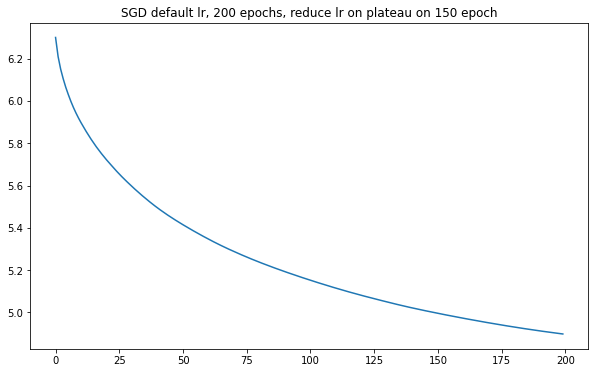

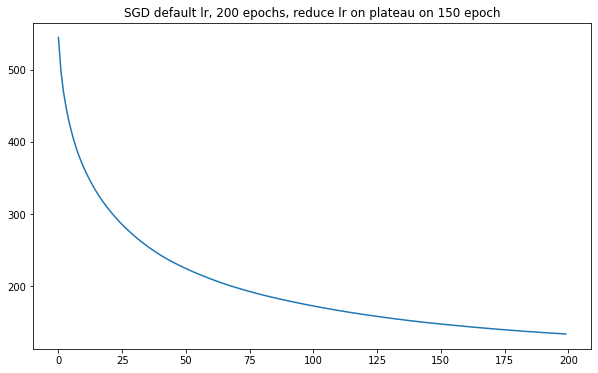

In [0]:
import pandas as pd

frame = pd.DataFrame(zip(train_loss_lstm_list,train_perp_lstm_list, test_loss_lstm_list,test_perp_lstm_list))
frame.columns = ['train_loss','train_perp','test_loss','test_perp']
frame.to_csv('1_LSTM(AdaBound).csv')

plt.figure(figsize=(10,6))
plt.title('SGD default lr, 200 epochs, reduce lr on plateau on 150 epoch')
plt.plot(range(200),frame['test_loss'])


plt.figure(figsize=(10,6))
plt.title('SGD default lr, 200 epochs, reduce lr on plateau on 150 epoch')
plt.plot(range(200),frame['test_perp'])

In [0]:
# import pandas as pd

# frame = pd.DataFrame(zip(train_loss_lstm_list,train_perp_lstm_list))
# frame.columns = ['train_loss','train_perp']
# frame.to_csv('1_LSTM(SGD).csv')

# plt.figure(figsize=(10,6))
# plt.title('SGD default lr, 200 epochs, reduce lr on plateau on 150 epoch')
# plt.plot(range(3),frame['train_loss'])


# plt.figure(figsize=(10,6))
# plt.title('SGD default lr, 200 epochs, reduce lr on plateau on 150 epoch')
# plt.plot(range(3),frame['train_perp'])